Once we have all weighted logSED values we need to plot a histogram of logSED and weighted logSED for both tissues.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import re
import ast
import os 
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set working directory
os.chdir("/pool01/projects/abante_lab/")

fig_path = "genomic_llms/borzoi/proc_results/figures/"

weighted_sed_path = "genomic_llms/borzoi/proc_results/weighted_logSED/"

/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Read concatenated weighted preds
preds = pl.concat(
    [pl.read_csv(os.path.join(weighted_sed_path, f), separator = '\t') 
     for f in os.listdir(weighted_sed_path) if f.endswith(".tsv.gz")]
)
preds.head()

snp,gene,alt_allele,tissue,logSED,chrom,pos,genehancer_id,weighted_logSED
str,str,str,str,f64,i64,i64,str,f64
"""21_33758366_C_G""","""ENSG00000170262""","""G""","""RNA-seq: Putamen""",-0.000042,21,32386057,"""GH21F032386""",-1.4165e-8
"""21_33758366_C_G""","""ENSG00000170262""","""G""","""RNA-seq: Caudate""",0.000055,21,32386057,"""GH21F032386""",1.8581e-8
"""21_33758366_C_G""","""ENSG00000232623""","""G""","""RNA-seq: Putamen""",-0.000236,21,32386057,"""GH21F032386""",-7.9922e-8
"""21_33758366_C_G""","""ENSG00000232623""","""G""","""RNA-seq: Caudate""",-0.000016,21,32386057,"""GH21F032386""",-5.5107e-9
"""21_33758366_C_G""","""ENSG00000142207""","""G""","""RNA-seq: Putamen""",-0.000137,21,32386057,"""GH21F032386""",-4.6384e-8


In [8]:
len(preds['chrom'].unique())

22

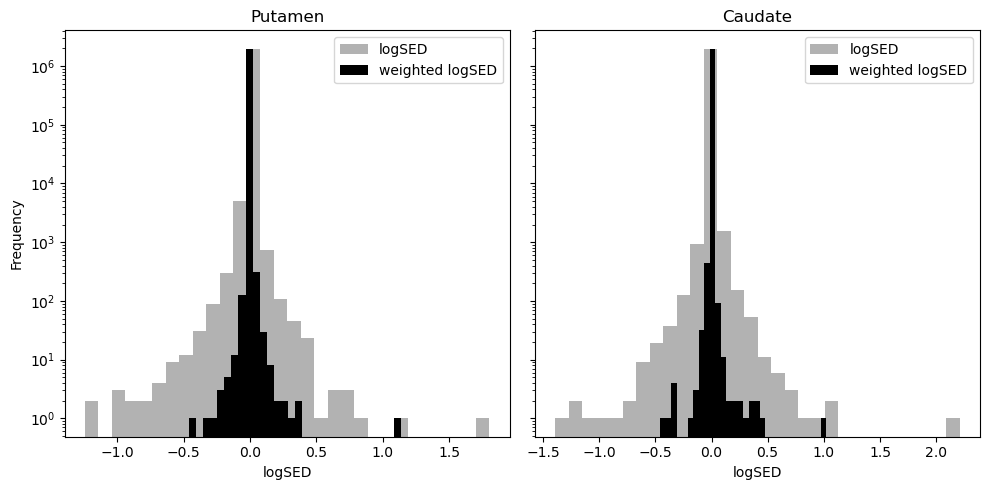

In [3]:
# Filter the dataframe
# Filter using Polars
preds1 = preds.filter(preds["tissue"] == "RNA-seq: Putamen")
preds2 = preds.filter(preds["tissue"] == "RNA-seq: Caudate")

# Convert to pandas for plotting
df1 = preds1.to_pandas()
df2 = preds2.to_pandas()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# RNA-seq: Putamen
axes[0].hist(df1["logSED"], bins=30, color='grey', alpha=0.6, label='logSED')
axes[0].hist(df1["weighted_logSED"], bins=30, color='black', label='weighted logSED')
axes[0].set_title("Putamen")
axes[0].set_xlabel('logSED')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].legend(loc='upper right')

# RNA-seq: Caudate
axes[1].hist(df2["logSED"], bins=30, color='grey', alpha=0.6, label='logSED')
axes[1].hist(df2["weighted_logSED"], bins=30, color='black', label='weighted logSED')
axes[1].set_title("Caudate")
axes[1].set_xlabel('logSED')
axes[1].set_yscale('log')
axes[1].legend(loc='upper right')

plt.tight_layout()
# plt.savefig(f"{fig_path}weighted_logSED.pdf", dpi=300)
plt.show()

In [11]:
# Extract largest logSED values gene
def extract_large_logSED(df, tissue, threshold=1.0):
    """Extract rows where |logSED| > threshold for a given tissue."""
    filtered_df = df[(df["tissue"] == tissue) & (df["logSED"] > threshold)]
    return filtered_df

# Extract top 10 largest logSED values for each tissue
top_putamen = extract_large_logSED(preds.to_pandas(), "RNA-seq: Putamen")
top_caudate = extract_large_logSED(preds.to_pandas(), "RNA-seq: Caudate")

top_putamen

,snp,gene,alt_allele,tissue,logSED,chrom,pos,genehancer_id,weighted_logSED
1530602,19_50651485_A_C,ENSG00000287001,C,RNA-seq: Putamen,1.802,19,50148228,GH19F050147,0.002271
1934366,1_157069597_G_A,ENSG00000253831,A,RNA-seq: Putamen,1.137,1,157099805,Promoter_ETV3L,1.137000


In [16]:
top_caudate

,snp,gene,alt_allele,tissue,logSED,chrom,pos,genehancer_id,weighted_logSED
1032669,5_60241142_G_A,ENSG00000164182,A,RNA-seq: Caudate,1.116,5,60945315,GH05F060943,0.000938
1530603,19_50651485_A_C,ENSG00000287001,C,RNA-seq: Caudate,2.210,19,50148228,GH19F050147,0.002785
1934367,1_157069597_G_A,ENSG00000253831,A,RNA-seq: Caudate,1.020,1,157099805,Promoter_ETV3L,1.020000


In [ ]:
# Manually looking for relevant loci 
large_loci = pd.DataFrame(columns=['snp', 'rsid', 'gene', 'gwas', 'tissue'])

large_loci.loc[0] = ['19_50651485_A_C', 'rs1809186999', 'ENSG00000287001', False, 'RNA-seq: Putamen']
large_loci.loc[1] = ['19_50651485_A_C', 'rs1809186999', 'ENSG00000287001', False, 'RNA-seq: Caudate']
large_loci.loc[2] = ['1_157069597_G_A', 'NA', 'ENSG00000253831', False, 'RNA-seq: Putamen']
large_loci.loc[3] = ['1_157069597_G_A', 'NA', 'ENSG00000253831', False, 'RNA-seq: Caudate']
large_loci.loc[4] = ['5_60241142_G_A', 'NA', 'ENSG00000164182', False, 'RNA-seq: Caudate']
